# CO2 quantity prediction

We have a dataset that contains records of atmospheric CO2 measurements at the Mauna Loa Observatory in Hawaii.
We will analyze our data in order to predict the quantity of CO2 in the atmosphere using gaussian process..

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.base import BaseEstimator

import warnings
warnings.simplefilter('ignore')

### Gaussian Process Implementation with RBF Kernel

In [2]:
def rbf_gram(X1, X2, sigma):
        X1, X2 = np.array(X1), np.array(X2)
        K = np.linalg.norm(X1[:, np.newaxis] - X2, axis=2) / sigma
        K = np.square(K)
        K = np.exp(-K)
        return K

In [3]:
class GaussianProcess():
    
    def __init__(self, fit_intercept=True, sigma=1e-10, alpha=0.0):
        self.sigma = sigma
        self.alpha = alpha
        self.fit_intercept = fit_intercept
        
    def fit(self, X, y):
        self.X = np.hstack( (np.ones((X.shape[0],1)), X) ) if self.fit_intercept else X
        self.mu = np.mean(y)
        self.y = y - np.mean(y)
        self.K = rbf_gram(self.X, self.X, self.sigma)
        
    def predict(self, X):
        X = np.hstack( (np.ones((X.shape[0],1)), X) ) if self.fit_intercept else X
        K_s = rbf_gram(self.X, X, self.sigma)
        L = np.linalg.cholesky(self.K + (self.alpha**2) * np.eye(self.K.shape[0]))
        Lv = np.linalg.inv(L)
        return K_s.T @ Lv.T @ Lv @ self.y + self.mu

### Exploratory Data Analysis

In [4]:
df = pd.read_csv("mauna_loa.csv")
df.drop(columns="Unnamed: 0", inplace=True)
df["co2"] = df["co2"].astype(float)

In [5]:
df.shape

(2225, 7)

Our dataframe contains 2225 observations and 7 variables.

In [6]:
df.head()

,year,month,day,weight,flag,station,co2
0,1958,3,29,4,0,MLO,316.1
1,1958,4,5,6,0,MLO,317.3
2,1958,4,12,4,0,MLO,317.6
3,1958,4,19,6,0,MLO,317.5
4,1958,4,26,2,0,MLO,316.4


Above is a preview of the contents of the dataframe which allows us to see the different variables.

In [7]:
df.isna().sum()

year       0
month      0
day        0
weight     0
flag       0
station    0
co2        0
dtype: int64

No missing values are observed in the dataframe.

In [8]:
df.nunique()

year        44
month       12
day         31
weight       7
flag         1
station      1
co2        581
dtype: int64

We see that some variables are constant, so they are unusable in our model.

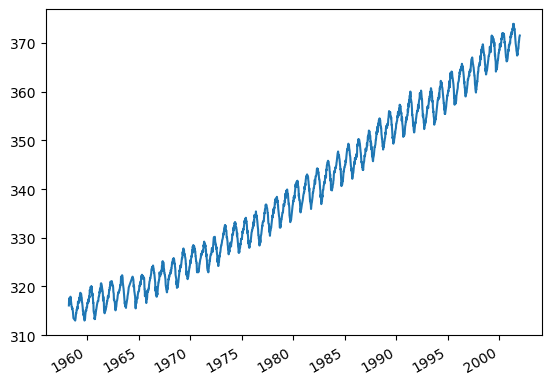

In [9]:
df.index = pd.to_datetime(df[["year", "month", "day"]])
df.co2.plot();

We observe growth in CO2 measurements in the atmosphere over the years.

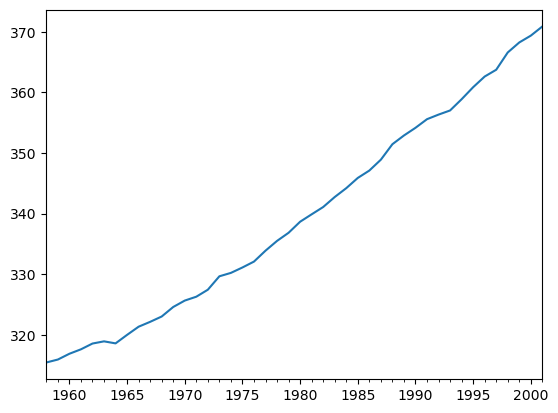

In [10]:
df.co2.resample("Y").mean().plot();

By taking the annual average, we can clearly see the growth in CO2 measurements in the atmosphere. We will need to manage this growing trend to be able to better model the target variable.

### Modèle

For evaluation, we will use RMSE as the metric.

In [11]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV

In [12]:
df_year = df[["year", "co2"]].groupby("year").mean().reset_index()
df_month = df[["year", "month", "co2"]].groupby(["year", "month"]).mean().reset_index()

Xm, ym = df_month.drop(columns="co2"), df_month.co2
Xy, yy = df_year.drop(columns="co2"), df_year.co2

We will model the increasing trend in CO2 measurements using a linear regression model.

In [13]:
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, random_state=42, test_size=0.2)
Xy_train, Xy_test, yy_train, yy_test = train_test_split(Xy, yy, random_state=42, test_size=0.2)

In [14]:
trend_m = [LinearRegression(), RidgeCV(alphas=np.arange(0.1, 2.0, 0.1)), LassoCV(alphas=np.arange(0.1, 2.0, 0.1))]
trend_y = [LinearRegression(), RidgeCV(alphas=np.arange(0.1, 2.0, 0.1)), LassoCV(alphas=np.arange(0.1, 2.0, 0.1))]

i = 0

for model in trend_m:
    model.fit(Xm_train, ym_train)
    print(f"RMSE{i}: ", MSE(ym_test, model.predict(Xm_test), squared=False))
    i += 1
    
for model in trend_y:
    model.fit(Xy_train, yy_train)
    print(f"RMSE{i}: ", MSE(yy_test, model.predict(Xy_test), squared=False))
    i += 1

RMSE0:  2.4805574815399374
RMSE1:  2.4804985106147255
RMSE2:  2.4710229392721565
RMSE3:  1.4420820966220336
RMSE4:  1.4429196140734475
RMSE5:  1.4432471446917805


In [15]:
trend = trend_y[0]

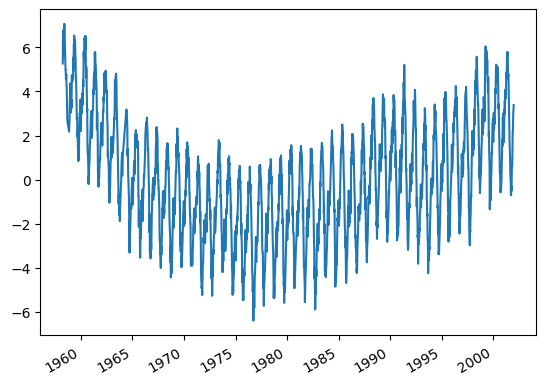

In [22]:
(df.co2 - trend.predict(df[["year"]])).plot();

We can see that we managed to remove the growing trend and obtain a target that we can predict more efficiently.

Now we will build a model to predict the amount of CO2 in the atmosphere.

In [16]:
X, y = df[["year", "month", "day", "weight"]], df.co2
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [17]:
class CustomGaussianProcess(GaussianProcess):
    
    def __init__(self, trend, sigma=1e-10, alpha=0.0):
        super().__init__(False, sigma, alpha)
        self.trend = trend
    
    def fit(self, X, y):
        super().fit(X, y - self.trend.predict(X[["year"]]))
        
    def predict(self, X):
        pred = super().predict(X)
        return pred + self.trend.predict(X[["year"]])

In [18]:
model = CustomGaussianProcess(trend)
model.fit(X_train, y_train)

In [19]:
print("RMSE: ", MSE(model.predict(X_test), y_test, squared=False))

RMSE:  2.444922948688335
